In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <BB02660F-1D5B-3388-B48B-486877D726F6> /Users/yujian/.pyenv/versions/3.10.1/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3), # 28 x 28 --> 26 x 26 x 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 13 x 13 x 4 
            nn.Flatten(), # --> (26 x 26 x 4)
            nn.Linear(13*13*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, X):
        logits = self.cnn(X)
        return logits

model = NeuralNetwork()
learning_rate = 1e-3
batch_size=64
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [4]:
training_data = datasets.FashionMNIST(root="../../fashion_mnist", train=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="../../fashion_mnist", train=False, transform=transforms.ToTensor())

In [5]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [6]:
kfold_validator = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
def train_loop(dataloader, model, loss_fn, _optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # predictions
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop
        _optimizer.zero_grad()
        loss.backward()
        _optimizer.step()

        if batch%100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Current loss: {loss:>7f}, [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return 100*correct

In [8]:
def optimize_loop(epoch_list, accuracy_list, epochs, train_dl, test_dl, _model, _optimizer):
    for t in range(epochs):
        print(f"Epoch {t+1}\n")
        train_loop(train_dl, _model, loss_fn, _optimizer)
        accuracy = test_loop(test_dl, _model, loss_fn)
        epoch_list.append(t)
        accuracy_list.append(accuracy)
    print("Done!")

In [9]:
def kfold_train_validate():
    for fold, (training_indices, validation_indices) in enumerate(kfold_validator.split(training_data)):
        subsampled_training_data = torch.utils.data.Subset(training_data, training_indices)
        subsampled_validation_data = torch.utils.data.Subset(training_data, validation_indices)
        train_dataloader = torch.utils.data.DataLoader(subsampled_training_data, batch_size=64)
        validation_dataloader = torch.utils.data.DataLoader(subsampled_validation_data, batch_size=64)
        plot_x = [] # epoch
        plot_y = [] # accuracy
        model = NeuralNetwork()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        optimize_loop(plot_x, plot_y, 5, train_dataloader, validation_dataloader, model, optimizer)
        torch.save(model.state_dict(),f'./fashion-mnist-cnn-fold-{fold}.pt')
        plt.plot(plot_x, plot_y)
        plt.savefig(f"fold-{fold}-accuracy.png")
        plt.show()

Epoch 1

Current loss: 2.306043, [    0/48000]
Current loss: 2.312394, [ 6400/48000]
Current loss: 2.306768, [12800/48000]
Current loss: 2.293159, [19200/48000]
Current loss: 2.296859, [25600/48000]
Current loss: 2.304902, [32000/48000]
Current loss: 2.297561, [38400/48000]
Current loss: 2.296733, [44800/48000]
Test Error:
 Accuracy: 14.7%, Avg loss: 2.293046

Epoch 2

Current loss: 2.292666, [    0/48000]
Current loss: 2.298991, [ 6400/48000]
Current loss: 2.293107, [12800/48000]
Current loss: 2.281010, [19200/48000]
Current loss: 2.282777, [25600/48000]
Current loss: 2.291859, [32000/48000]
Current loss: 2.283129, [38400/48000]
Current loss: 2.280467, [44800/48000]
Test Error:
 Accuracy: 25.6%, Avg loss: 2.277077

Epoch 3

Current loss: 2.278119, [    0/48000]
Current loss: 2.283010, [ 6400/48000]
Current loss: 2.273625, [12800/48000]
Current loss: 2.261597, [19200/48000]
Current loss: 2.256878, [25600/48000]
Current loss: 2.265962, [32000/48000]
Current loss: 2.253747, [38400/48000]

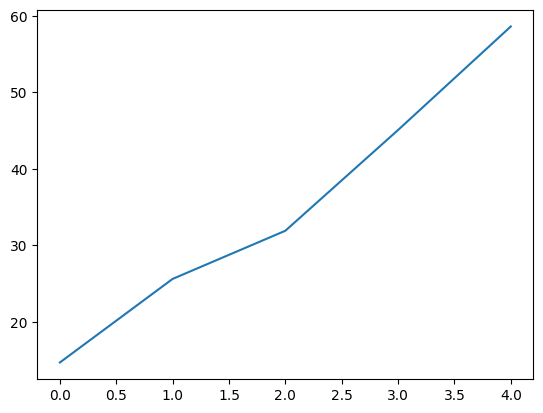

Epoch 1

Current loss: 2.298782, [    0/48000]
Current loss: 2.293710, [ 6400/48000]
Current loss: 2.290671, [12800/48000]
Current loss: 2.298489, [19200/48000]
Current loss: 2.284718, [25600/48000]
Current loss: 2.265476, [32000/48000]
Current loss: 2.253768, [38400/48000]
Current loss: 2.243629, [44800/48000]
Test Error:
 Accuracy: 33.3%, Avg loss: 2.231183

Epoch 2

Current loss: 2.229298, [    0/48000]
Current loss: 2.203176, [ 6400/48000]
Current loss: 2.189262, [12800/48000]
Current loss: 2.173813, [19200/48000]
Current loss: 2.156247, [25600/48000]
Current loss: 2.118239, [32000/48000]
Current loss: 2.063482, [38400/48000]
Current loss: 2.043859, [44800/48000]
Test Error:
 Accuracy: 50.6%, Avg loss: 1.997806

Epoch 3

Current loss: 2.030206, [    0/48000]
Current loss: 1.906635, [ 6400/48000]
Current loss: 1.831460, [12800/48000]
Current loss: 1.754902, [19200/48000]
Current loss: 1.707179, [25600/48000]
Current loss: 1.650587, [32000/48000]
Current loss: 1.489560, [38400/48000]

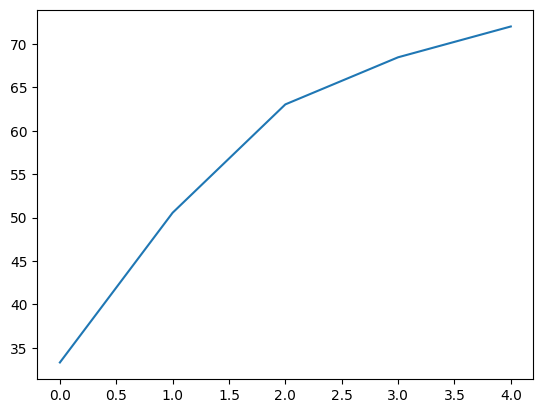

Epoch 1

Current loss: 2.307416, [    0/48000]
Current loss: 2.303986, [ 6400/48000]
Current loss: 2.284711, [12800/48000]
Current loss: 2.287850, [19200/48000]
Current loss: 2.291573, [25600/48000]
Current loss: 2.282741, [32000/48000]
Current loss: 2.286072, [38400/48000]
Current loss: 2.291336, [44800/48000]
Test Error:
 Accuracy: 13.3%, Avg loss: 2.282281

Epoch 2

Current loss: 2.285779, [    0/48000]
Current loss: 2.282688, [ 6400/48000]
Current loss: 2.268810, [12800/48000]
Current loss: 2.269242, [19200/48000]
Current loss: 2.270412, [25600/48000]
Current loss: 2.262111, [32000/48000]
Current loss: 2.263688, [38400/48000]
Current loss: 2.268339, [44800/48000]
Test Error:
 Accuracy: 31.3%, Avg loss: 2.253690

Epoch 3

Current loss: 2.256345, [    0/48000]
Current loss: 2.250992, [ 6400/48000]
Current loss: 2.239963, [12800/48000]
Current loss: 2.232789, [19200/48000]
Current loss: 2.229888, [25600/48000]
Current loss: 2.217164, [32000/48000]
Current loss: 2.209146, [38400/48000]

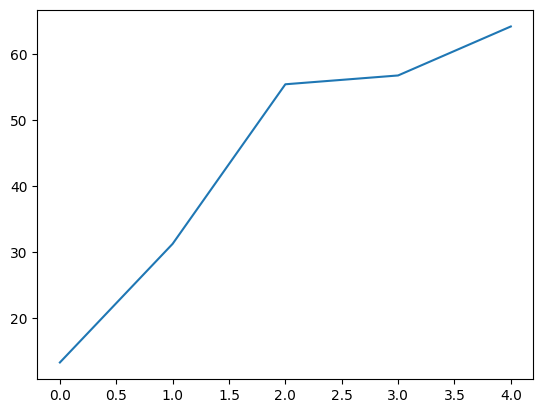

Epoch 1

Current loss: 2.326503, [    0/48000]
Current loss: 2.294744, [ 6400/48000]
Current loss: 2.272259, [12800/48000]
Current loss: 2.271203, [19200/48000]
Current loss: 2.266059, [25600/48000]
Current loss: 2.274465, [32000/48000]
Current loss: 2.242514, [38400/48000]
Current loss: 2.247255, [44800/48000]
Test Error:
 Accuracy: 26.5%, Avg loss: 2.221973

Epoch 2

Current loss: 2.235622, [    0/48000]
Current loss: 2.200350, [ 6400/48000]
Current loss: 2.165672, [12800/48000]
Current loss: 2.163521, [19200/48000]
Current loss: 2.113184, [25600/48000]
Current loss: 2.112998, [32000/48000]
Current loss: 2.044475, [38400/48000]
Current loss: 2.045601, [44800/48000]
Test Error:
 Accuracy: 49.1%, Avg loss: 1.969007

Epoch 3

Current loss: 1.978331, [    0/48000]
Current loss: 1.935939, [ 6400/48000]
Current loss: 1.854541, [12800/48000]
Current loss: 1.849897, [19200/48000]
Current loss: 1.686416, [25600/48000]
Current loss: 1.648135, [32000/48000]
Current loss: 1.542767, [38400/48000]

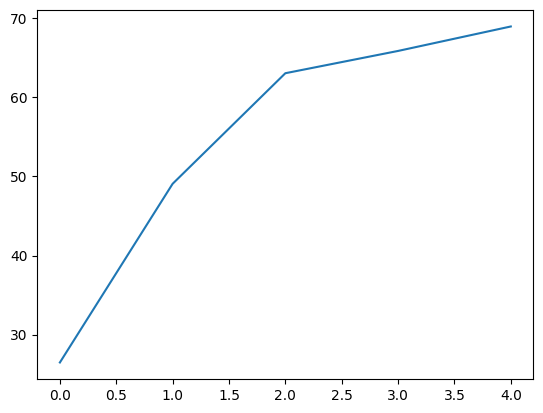

Epoch 1

Current loss: 2.305626, [    0/48000]
Current loss: 2.301965, [ 6400/48000]
Current loss: 2.286221, [12800/48000]
Current loss: 2.294080, [19200/48000]
Current loss: 2.300016, [25600/48000]
Current loss: 2.304259, [32000/48000]
Current loss: 2.289903, [38400/48000]
Current loss: 2.289599, [44800/48000]
Test Error:
 Accuracy: 10.1%, Avg loss: 2.287758

Epoch 2

Current loss: 2.289542, [    0/48000]
Current loss: 2.283014, [ 6400/48000]
Current loss: 2.278641, [12800/48000]
Current loss: 2.281761, [19200/48000]
Current loss: 2.281329, [25600/48000]
Current loss: 2.283090, [32000/48000]
Current loss: 2.267410, [38400/48000]
Current loss: 2.269879, [44800/48000]
Test Error:
 Accuracy: 33.2%, Avg loss: 2.263497

Epoch 3

Current loss: 2.262601, [    0/48000]
Current loss: 2.246647, [ 6400/48000]
Current loss: 2.254658, [12800/48000]
Current loss: 2.246086, [19200/48000]
Current loss: 2.233258, [25600/48000]
Current loss: 2.231658, [32000/48000]
Current loss: 2.203622, [38400/48000]

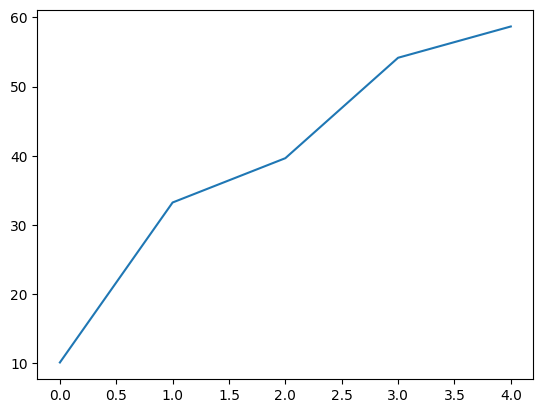

In [10]:
kfold_train_validate()